# Data Cleaning and Processing

In this stage, we will perform cleaning and processing on the data after having done the exploratory data analysis on the three datasets.
[[Link to data exploration notebook](./exploration.ipynb)]

In [1]:
# Install all dependencies
%pip install -r ../requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\Gregory\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Import Libraries and Dependencies

In [2]:
import sys
sys.path.append('../src/')

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import boxcox
import joblib

# Import custom plots
from customPlots.plotting import plot_corr

In [4]:
# Load dataset
loan_df = pd.read_csv('../data/loan.csv')
payment_df = pd.read_csv('../data/payment.csv')

In [5]:
print('Shape of Data before preprocessing')
print(f'loan_df --> {loan_df.shape}')
print(f'payment_df --> {payment_df.shape}')

Shape of Data before preprocessing
loan_df --> (577682, 19)
payment_df --> (689364, 9)


## Data Preprocessing

In [6]:
# Create a replica to perform transformation and processing
cln_loan_df = loan_df.copy()

cln_loan_df.shape

(577682, 19)

In [7]:
# Filter out loans that were not funded
cln_loan_df = cln_loan_df[cln_loan_df['isFunded'] == 1].reset_index(drop=True)
cln_loan_df = cln_loan_df.drop(['originated','originatedDate','approved','isFunded'], axis=1)

cln_loan_df.shape

(38982, 15)

In [8]:
# Fix missing value
cln_loan_df['nPaidOff'] = loan_df['nPaidOff'].fillna(0)
cln_loan_df['fpStatus'] = loan_df['fpStatus'].fillna('None')

cln_loan_df.isna().sum()

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
nPaidOff                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               0
clarityFraudId                      6622
hasCF                                  0
dtype: int64

In [9]:
# Drop clarityFraudID due to too many missing values and difficult to impute
cln_loan_df = cln_loan_df.drop(['clarityFraudId'], axis=1)

In [10]:
# Data Transformation to treat skewness
columns = ['apr','loanAmount','originallyScheduledPaymentAmount','leadCost']
for column in columns:
    #print(np.log(cln_loan_df[column]).agg(['skew','kurtosis']))
    # print(np.sqrt(cln_loan_df[column]).agg(['skew','kurtosis']))
    # print(pd.Series(boxcox(cln_loan_df[column] + 0.001)[0]).agg(['skew','kurtosis']))
    
    cln_loan_df[column], lam = boxcox(cln_loan_df[column] + 0.001)

cln_loan_df[columns].agg(['skew','kurtosis'])

,apr,loanAmount,originallyScheduledPaymentAmount,leadCost
skew,-0.389640,0.004874,-0.007912,-0.369793
kurtosis,-1.084736,0.514298,0.270479,-0.997360


In [11]:
# Data Binning
cln_loan_df['nPaidOff'] = pd.cut(cln_loan_df['nPaidOff'], bins=[-1, 0, 5, 10, 20], labels=False)
cln_loan_df['nPaidOff'].describe()

count    38982.000000
mean         0.025268
std          0.160496
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: nPaidOff, dtype: float64

In [12]:
# label Encoding
columns = ['fpStatus','loanStatus','payFrequency','state','leadType']
label_encode_store = {}

for column in columns:
    label_encoder = LabelEncoder()
    cln_loan_df[column] = label_encoder.fit_transform(cln_loan_df[column])
    label_encode_store[column] = label_encoder
    print(cln_loan_df[column].value_counts())

# Save the label encoder for future use
for column, encoder in label_encode_store.items():
    filename = f'label_encoder_{column}.pkl'
    joblib.dump(encoder, f'../misc/{filename}')

fpStatus
4    35459
1     2233
2      801
5      365
3       85
6       21
0       18
Name: count, dtype: int64
loanStatus
5     11427
2     11334
4      8112
3      5564
7      1182
9       708
8       325
6       169
1       159
0         1
10        1
Name: count, dtype: int64
payFrequency
0    22797
4    10248
2     2880
3     2628
1      429
Name: count, dtype: int64
state
28    6563
12    5145
35    3071
39    2582
20    2129
7     1801
18    1699
13    1691
3     1640
22    1545
37    1366
30    1354
34    1299
25    1216
32     888
2      610
27     548
4      457
5      353
19     353
15     297
1      245
38     243
26     222
16     222
36     200
21     190
8      144
29     138
10     131
14     128
33      88
40      77
6       74
24      71
31      51
9       48
11      48
0       30
23      23
17       2
Name: count, dtype: int64
leadType
0    16569
4    11572
6     7598
8     1843
7     1307
1       49
2       16
5       10
3        9
9        9
Name: count, dtype: int

In [13]:
# Group and aggregate the payment_df
groups = {
    'Paid': ['Checked', 'Complete'],
    'Pending': ['Pending','Rejected Awaiting Retry'],
    'Missed': ['Rejected','Skipped','Returned'],
    'Cancelled': ['Cancelled']
}

payment_grouped_df = pd.DataFrame(payment_df['loanId'].unique()).rename(columns={0:'loanId'})

for group in groups:
    grouped = payment_df[payment_df['paymentStatus'].isin(groups[group])].groupby('loanId')
    
    totalPrincipal = grouped['principal'].sum().reset_index(name=f'TotalPrincipal{group}')
    totalFees = grouped['fees'].sum().reset_index(name=f'TotalFees{group}')
    numPayments = grouped.size().reset_index(name=f'NumPayments{group}')
    
    payment_grouped_df = payment_grouped_df.merge(totalPrincipal, how='left', on='loanId').merge(totalFees, how='left', on='loanId').merge(numPayments, how='left', on='loanId')

payment_grouped_df.head()

,loanId,TotalPrincipalPaid,TotalFeesPaid,NumPaymentsPaid,TotalPrincipalPending,TotalFeesPending,NumPaymentsPending,TotalPrincipalMissed,TotalFeesMissed,NumPaymentsMissed,TotalPrincipalCancelled,TotalFeesCancelled,NumPaymentsCancelled
0,LL-I-00000021,697.84,1167.77,12.0,NaN,NaN,NaN,102.17,67.44,1.0,NaN,NaN,NaN
1,LL-I-00000231,27.20,231.44,2.0,NaN,NaN,NaN,70.33,278.63,2.0,702.47,693.24,8.0
2,LL-I-00000238,259.46,903.14,7.0,NaN,NaN,NaN,74.96,99.52,1.0,465.58,232.21,4.0
3,LL-I-00000308,3.61,57.98,1.0,NaN,NaN,NaN,4.67,56.92,1.0,191.72,424.18,10.0
4,LL-I-00000355,NaN,NaN,NaN,NaN,NaN,NaN,0.00,52.60,1.0,500.00,699.46,11.0


In [14]:
payment_grouped_df.isna().sum()

loanId                         0
TotalPrincipalPaid          7784
TotalFeesPaid               7784
NumPaymentsPaid             7784
TotalPrincipalPending      31687
TotalFeesPending           31687
NumPaymentsPending         31687
TotalPrincipalMissed       20437
TotalFeesMissed            20437
NumPaymentsMissed          20437
TotalPrincipalCancelled    17235
TotalFeesCancelled         17235
NumPaymentsCancelled       17235
dtype: int64

In [15]:
payment_grouped_df = payment_grouped_df.fillna(0)

In [16]:
# Merge payment_df with loan_df
df = pd.merge(cln_loan_df, payment_grouped_df, how='inner', on='loanId')

df.shape

(38878, 26)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38878 entries, 0 to 38877
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   loanId                            38878 non-null  object 
 1   anon_ssn                          38878 non-null  object 
 2   payFrequency                      38878 non-null  int32  
 3   apr                               38878 non-null  float64
 4   applicationDate                   38878 non-null  object 
 5   nPaidOff                          38878 non-null  int64  
 6   loanStatus                        38878 non-null  int32  
 7   loanAmount                        38878 non-null  float64
 8   originallyScheduledPaymentAmount  38878 non-null  float64
 9   state                             38878 non-null  int32  
 10  leadType                          38878 non-null  int32  
 11  leadCost                          38878 non-null  float64
 12  fpSt

In [18]:
# Filter out loans that have not completed payment cycle
df = df[df['NumPaymentsPending'] == 0]
df = df[~df['loanStatus'].isin(['New Loan','Pending Paid Off','Pending Application Fee','Pending Rescind','Pending Application'])]

df = df.drop(['TotalPrincipalPending','TotalFeesPending','NumPaymentsPending'], axis=1)

df.shape

(30620, 23)

## Feature Engineering

In [19]:
# whether the loan has been paid off fully
df['isPaidOff'] = (df['loanAmount'] <= df['TotalPrincipalPaid']).astype(int)
df['isPaidOff'].value_counts()

isPaidOff
1    24140
0     6480
Name: count, dtype: int64

`isPaidOff`: 1 for loan has been fully paid off, and 0 for loan that has not due to it being settled or defaulted. This will be the **target** of the later analysis.

In [20]:
# calculate the number of loans borrowed
user_group = df.groupby('anon_ssn')
totalLoans = user_group.size().reset_index(name="nLoanTaken")

df = pd.merge(df, totalLoans, how='left', on='anon_ssn')
df['nLoanTaken'].describe()

count    30620.000000
mean         1.297257
std          0.723743
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         12.000000
Name: nLoanTaken, dtype: float64

`nLoanTaken`: the total number of loans taken by the same customer

In [21]:
# calculate the return-on-investment
df['ROI'] = ((df['TotalPrincipalPaid'] + df['TotalFeesPaid']) - df['loanAmount'])/df['loanAmount']
df['ROI'].describe()

count    30620.000000
mean       442.322489
std        508.586973
min         -1.000000
25%         71.689003
50%        306.256357
75%        630.629076
max       5837.205447
Name: ROI, dtype: float64

`ROI`: the total return in investment and borrowing the loan to the customer

In [22]:
# calculate the actual earnings vs expected earnings
df['earningDiff'] = ((df['TotalPrincipalPaid'] + df['TotalFeesPaid']) - df['originallyScheduledPaymentAmount'])
df['earningDiff'].describe()

count    30620.000000
mean       642.345736
std        742.781317
min         -2.286653
25%        103.138777
50%        442.998586
75%        914.615669
max       8554.304118
Name: earningDiff, dtype: float64

`earningDiff`: the total difference in the actual earning (total collected) vs the expected earning (originally scheduled to collect)

In [23]:
# aggregate application date
df['applicationYear'] = df['applicationDate'].str.extract(r'(\d{4})').astype(int)
df['applicationYear'].value_counts()

applicationYear
2016    16108
2015     8395
2017     5973
2014      144
Name: count, dtype: int64

`applicationYear`: the year where the application of the loan was made.

In [24]:
# drop since they have been aggregated
df = df.drop(['TotalPrincipalPaid','TotalFeesPaid','TotalPrincipalMissed','TotalFeesMissed','TotalPrincipalCancelled','TotalFeesCancelled'], axis=1)

# drop object type columns
df = df.drop(['loanId','anon_ssn','applicationDate'], axis=1)

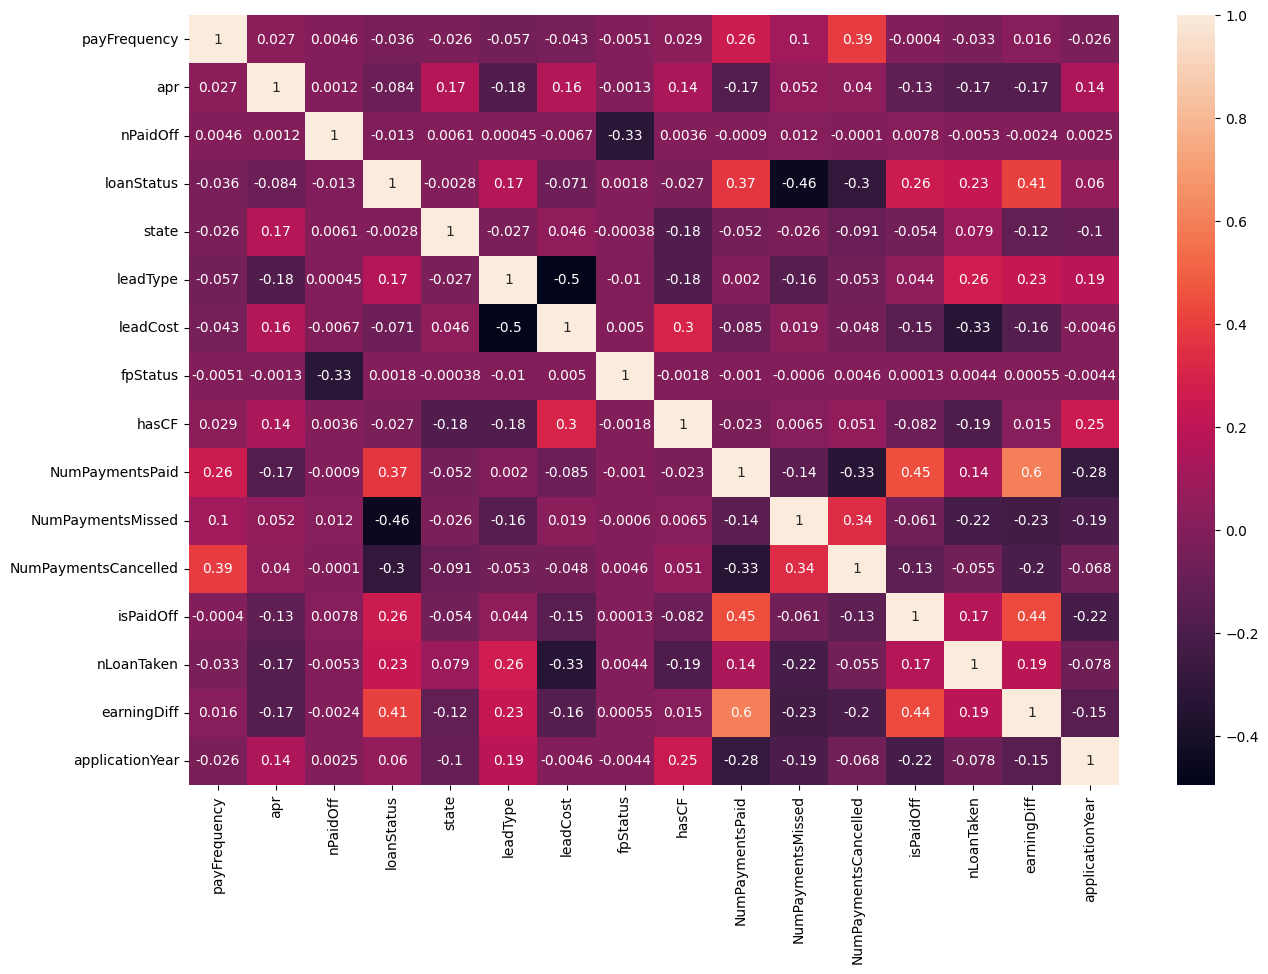

In [28]:
# check for correlation
plot_corr(df)

In [26]:
# drop those features that are highly correlated
df = df.drop(['ROI','originallyScheduledPaymentAmount','loanAmount'], axis=1)

In [27]:
df.to_csv('../data/cleaned_data.csv') # save dataframe